HIV (then it's progression to AIDS) is unique because it won't kill you like other nasty viruses will. Rather it will leave you extrodinarily vulnerable to other viruses with a prolonged time with no symptoms (AIDS). 

Antiretroviral treatment is used to treat aids by limited the growth of HIV in the body. Control theory is neccecary to prevent over treating patience as it has adverse effects on the patient. 

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn

In [3]:
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h
def RK4(f, y0, t0, t, n):
    """ 
    f is assumed to accept three arguments.
        - The first is a constant giving the value of t.
        - The second is a one-dimensional numpy array of the same size as y.
        - The third is an index to the other arrays.
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the ith value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

In [4]:
a_1, a_2 = 0., 0.
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025
g = 30.
c = 0.007
B_1, B_2 = 14., 1.
A_1, A_2 = 250000., 75.
T0, V0 = 400., 3.
t_f = 50.
n = 1000

state = np.zeros((n,2))
state0 = np.array([T0, V0])
costate = np.zeros((n,2))
costate0 = np.zeros(2)
u=np.zeros((n,2))
u[:,0] += .02
u[:,1] += .9
# define state equations
def state_equations(t,y,i):
    """Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the T cell concentration and the Virus concentration at time t
    i : int
    index for the global variable u.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the T cell concentration and the virus ←-
    concentration at time t
    """
    return np.array([s_1 - (s_2*y[1])/(B_1+y[1]) - mu*y[0] - k*y[1]*y[0] + u[i][0]*y[0], ((g*y[1])/(B_2 + y[1]))*(1 - u[i][1]) - c*y[1]*y[0]])

In [5]:
state = RK4(state_equations, state0, 0, t_f, n)

In [6]:
def lambda_hat(t,y,i):
    """
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    """
    #i = i + 1
    lam1, lam2 = y[0], y[1]
    lam_hat1 = lam1*(-mu - k * state[-i, 1] + u[-i, 0]) - c*lam2*state[-i, 1] - 1
    lam_hat2 = -lam1*(((s_2*B_1)/(B_1 + state[-i, 1])**2) + k*state[-i, 0]) + lam2*(((g*B_2*(1 - u[-i, 1]))/(B_2 + state[-i, 1])**2) - c*state[-i, 0])
    return np.array([lam_hat1, lam_hat2])

In [7]:
costate = RK4(lambda_hat, costate0, 0 ,t_f, n)[::-1]

In [8]:
epsilon = 0.001
test = epsilon + 1
a_1_extended = np.linspace(a_1,a_1,n)
b_1_extended = np.linspace(b_1,b_1,n)
a_2_extended = np.linspace(a_2,a_2,n)
b_2_extended = np.linspace(b_2,b_2,n)
while(test > epsilon):
    oldu = u.copy()
    #solve the state equations with forward iteration
    state = RK4(state_equations, state0, 0, t_f, n)
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat, costate0, 0 ,t_f, n)[::-1]
    #solve for u1 and u2
    
    u1 = np.minimum(np.maximum(a_1_extended, -1/(2*A_1) * np.multiply(costate[:, 0],state[:, 0])), b_1_extended)
    u2 = np.minimum(np.maximum(a_2_extended, 1/(2*A_2)* np.multiply(costate[:, 1], g*state[:,1]/(B_2 + state[:, 1]))), b_2_extended)
    
    #update control
    
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    #test for convergence
    test = abs(oldu - u).sum()

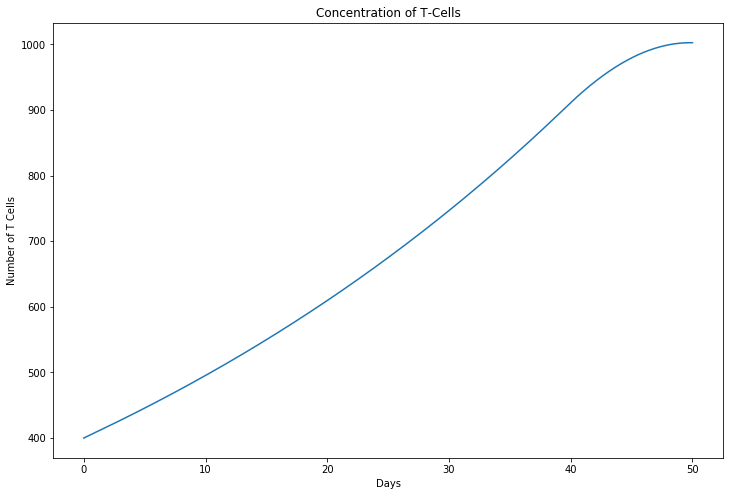

In [10]:
time = np.linspace(0,t_f,n)

figure(figsize=(12, 8))
plt.plot(time,state[:, 0])
plt.title("Concentration of T-Cells")
plt.xlabel('Days')
plt.ylabel('Number of T Cells')
plt.show()

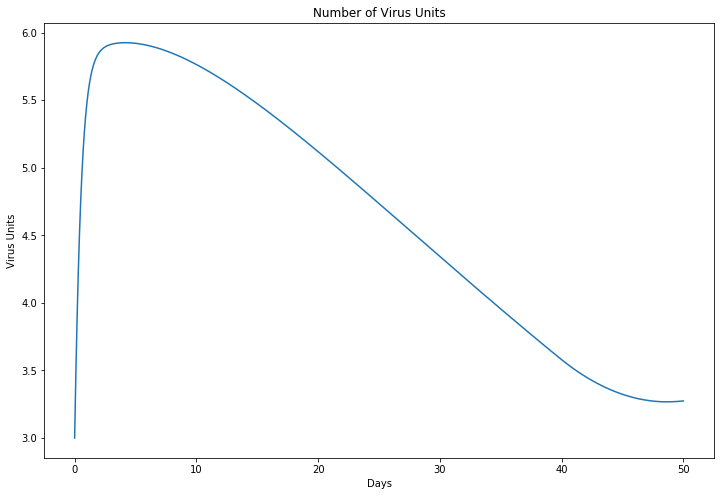

In [11]:
figure(figsize=(12, 8))
plt.plot(time,state[:, 1])
plt.title('Number of Virus Units')
plt.ylabel('Virus Units')
plt.xlabel('Days')
plt.show()

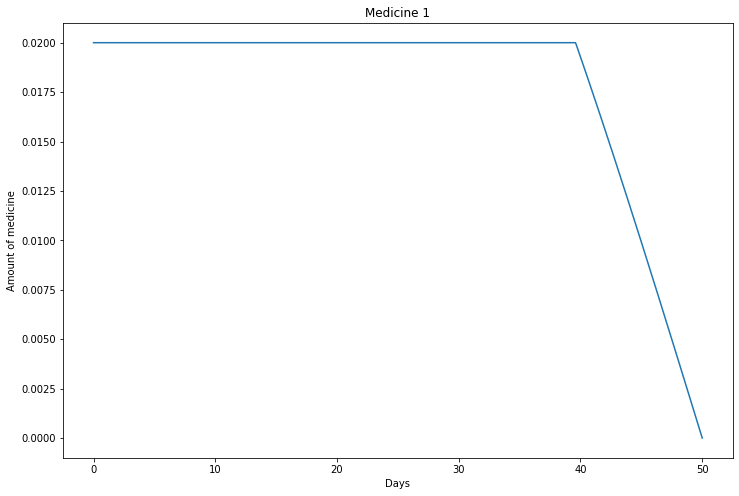

In [12]:
figure(figsize=(12, 8))
plt.plot(time,u1)
plt.title('Medicine 1')
plt.ylabel('Amount of medicine')
plt.xlabel('Days')
plt.show()

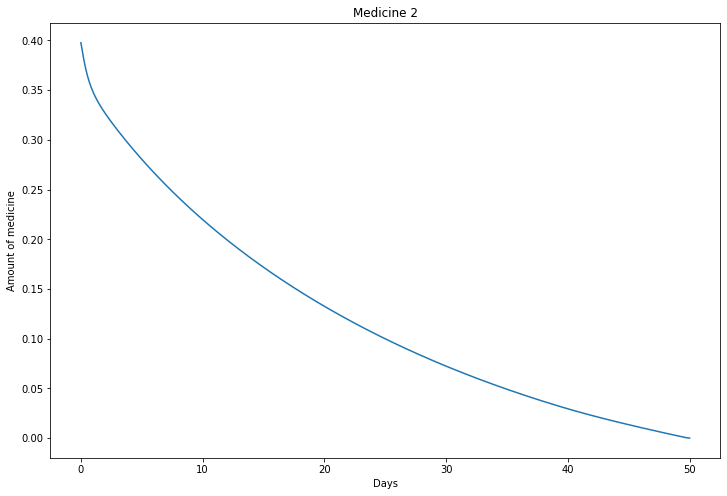

In [13]:
figure(figsize=(12, 8))
plt.plot(time,u2)
plt.title('Medicine 2')
plt.ylabel('Amount of medicine')
plt.xlabel('Days')
plt.show()